## Building up tVMC

Next step - Fix KE calculation for complex psis, make it consistent with the analytical model

In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import jax
import jax.numpy as jnp
from sampling import metropolis_step
from local_energy import get_local_energy_fn
import matplotlib.pyplot as plt

In [3]:
key = jax.random.key(seed=3)
pos = jax.random.normal(key, (4200, 3))

### Hydrogen superposition - relative phase beating mode

In [27]:
def f(params, x):
    """
    Wavefunction representing the superposition of the ground and first excited state of Hydrogen.
    params: theta (relative phase between 1s and 2s)
    """
    r = jnp.linalg.norm(x)
    
    # 1s wavefunction (ground state)
    psi_1s = (1 / jnp.sqrt(jnp.pi)) * jnp.exp(-r)
    
    # 2s wavefunction (first excited state)
    psi_2s = (1 / (4 * jnp.sqrt(2 * jnp.pi))) * (2 - r) * jnp.exp(-r / 2)
    
    # Superposition with relative phase on 2s state
    theta = params.squeeze()
    return (psi_1s + psi_2s * jnp.exp(-1j * theta)) / jnp.sqrt(2)

batched_f = jax.jit(jax.vmap(f, in_axes=(None, 0)))

In [28]:
params = jnp.array([0.0])
te = get_local_energy_fn(f, 1, 1)

In [37]:
o_alpha = jax.jacfwd(lambda p: batched_f(p, pos))(params)
o_alpha_centered = o_alpha - jnp.mean(o_alpha, axis=0, keepdims=True)
s = jnp.real(jnp.dot(jnp.conj(o_alpha_centered).T, o_alpha_centered) / o_alpha.shape[0])

In [38]:
s

Array([[0.00125626]], dtype=float32)

In [31]:
pos = jax.random.uniform(key, (4200, 3))

In [32]:
def get_energy_mean_variance(energies):
    me = jnp.mean(energies)
    var = jnp.mean((energies - me) ** 2)
    return me, var

In [33]:
mc_step = metropolis_step(params, batched_f, pos, key)

In [34]:
# Warmup steps
key, subkey = jax.random.split(key)
pos = jax.random.uniform(subkey, (4200, 3))

for i in range(200):
    key, subkey = jax.random.split(key)
    pos, pmove = mc_step(params, pos, subkey, mcmc_width=0.5)
print(pmove)

0.67280954


In [35]:
energies = te(params, pos)

In [36]:
get_energy_mean_variance(energies)

(Array(-0.32524034+0.j, dtype=complex64),
 Array(0.03330005+0.j, dtype=complex64))

In [343]:
dt = 1e-2

In [76]:
def get_update(params, pos):
    """Gets theta dot"""
    # Compute log-derivative O_alpha = d(log psi)/d(theta)
    o_alpha = jax.jacfwd(lambda p: jnp.log(batched_f(p, pos)))(params)
    o_alpha = o_alpha.squeeze()  # shape: (n_samples,)
    
    # Quantum geometric tensor S
    o_alpha_centered = o_alpha - jnp.mean(o_alpha)
    s = jnp.real(jnp.mean(jnp.conj(o_alpha_centered) * o_alpha_centered))
    
    # Local energy
    energy = te(params, pos)  # shape: (n_samples,)
    
    # Force term F = <O_alpha^* E_L> - <O_alpha^*><E_L>
    F = jnp.mean(jnp.conj(o_alpha) * energy) - jnp.mean(jnp.conj(o_alpha)) * jnp.mean(energy)
    
    # Equation: S * theta_dot = -i * F
    # So: theta_dot = Re(-i * F) / S = Im(F) / S
    theta_dot = jnp.imag(F) / s
    
    print(f"S = {s:.6f}, F = {F:.6f}, theta_dot = {theta_dot:.6f}")
    
    return theta_dot

update_fn = jax.jit(get_update)

In [77]:
get_update(params, pos)

S = 0.006094, F = -0.000000+0.002285j, theta_dot = 0.375003


Array(0.37500286, dtype=float32)

In [71]:
psi = batched_f(params, pos)
dpsi = jax.jacfwd(lambda p: batched_f(p, pos))(params)
print(f"psi.shape = {psi.shape}")
print(f"dpsi.shape = {dpsi.shape}")
print(f"params.shape = {params.shape}")
print(f"pos.shape = {pos.shape}")

psi.shape = (200,)
dpsi.shape = (200, 1)
params.shape = (1,)
pos.shape = (200, 3)


In [51]:
energy = te(params, pos)

In [52]:
dt = 1e-2

In [59]:

r_expect = []
for i in range(5000):
    #key, subkey = jax.random.split(key)
    #pos = jax.random.uniform(subkey, (200, 3))

    #for j in range(30):
    #    key, subkey = jax.random.split(key)
    #    pos, pmove = mc_step(params, pos, subkey, 0.5)
        
    theta_dot = get_update(params, pos)
    #print(theta_dot)

    params = params + dt * theta_dot
    density = jnp.abs(batched_f(params, pos)) ** 2

    r = jnp.linalg.norm(pos, axis=1)
    r_exp = jnp.mean(r)
    r = jnp.linalg.norm(pos, axis=1)

    r_expect_t = jnp.sum(density * r) / jnp.sum(density)
    r_expect.append(r_expect_t)
    Eloc = te(params, pos)
    #r_expect.append(r_exp)
    #print(r_exp)
    if i % 1000 == 0:
        print(f"Elocal {jnp.mean(Eloc)}")
        print(f"Evar {jnp.mean((Eloc - jnp.mean(Eloc)) ** 2)}")

0.37499928
Elocal (-0.6434953212738037+0.048088520765304565j)
Evar (0.0005715175066143274-0.0005924223805777729j)
0.3750064
0.37499708
0.37499657
0.37499478
0.3750017
0.3750071
0.3750031
0.37499988
0.37500775
0.37499544
0.37499914
0.37500066
0.37499988
0.3750019
0.3749987
0.3750034
0.37499738
0.37499902
0.37500563
0.37499583
0.37499604
0.37500623
0.37499958
0.3750001
0.3750022
0.37500587
0.37500283
0.37499848
0.37498993
0.37499857
0.3749974
0.37500796
0.37500015
0.37499854
0.37501106
0.375002
0.3749932
0.37500125
0.37499818
0.375009
0.37500018
0.3749937
0.3749869
0.3750076
0.37500226
0.37500197
0.37499496
0.3749983
0.3750063
0.37500444
0.3749955
0.3750022
0.37499866
0.37499928
0.37499502
0.37500048
0.3750038
0.37500197
0.37499192
0.375006
0.37499964
0.37500542
0.37500244
0.37499946
0.37499934
0.37500203
0.37500757
0.3750034
0.3749957
0.37500262
0.37499952
0.3749987
0.3750029
0.37499985
0.37500492
0.37499934
0.37499845
0.374996
0.37499502
0.37500173
0.37500343
0.37499988
0.37500384
0.37

Getting peak frequency
Extracted ω: 0.37699111843077515


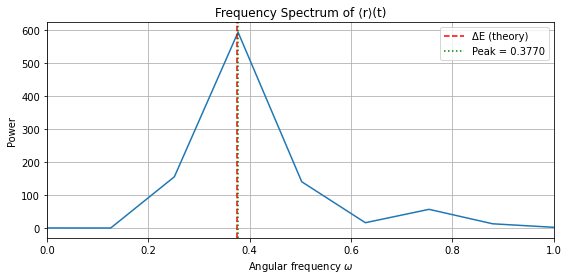

In [63]:

import numpy as np

print("Getting peak frequency")
r_expect = jnp.array(r_expect)
signal = r_expect - jnp.mean(r_expect)
dt = 0.01

fft_vals = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2

idx = np.argmax(power[1:]) + 1   # skip zero frequency
f_peak = freqs[idx]

omega_peak = 2 * np.pi * f_peak
print("Extracted ω:", omega_peak)


signal = r_expect - np.mean(r_expect)
window = np.hanning(len(signal))

fft_vals = np.fft.rfft(signal * window)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2
omega = 2 * np.pi * freqs

plt.figure(figsize=(8, 4))
plt.plot(omega, power)
plt.axvline(0.375, color="red", linestyle="--", label="ΔE (theory)")
plt.axvline(omega[np.argmax(power[1:]) + 1],
            color="green", linestyle=":",
            label=f"Peak = {omega[np.argmax(power[1:]) + 1]:.4f}")

plt.xlim(0, 1.0)
plt.xlabel(r"Angular frequency $\omega$")
plt.ylabel("Power")
plt.title("Frequency Spectrum of ⟨r⟩(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

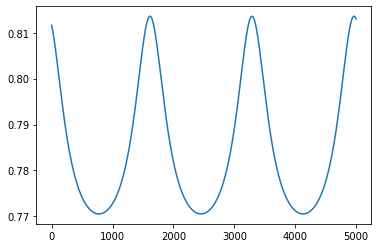

In [60]:
plt.plot(r_expect)

## Exactly solved version

### Radial Grid

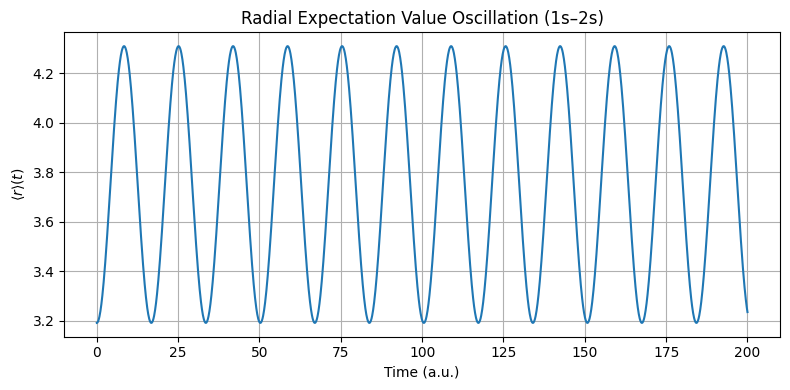

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Energies (atomic units)
# -------------------------
E1 = -0.5
E2 = -0.125
omega = E2 - E1

# -------------------------
# Radial grid
# -------------------------
r = np.linspace(0, 40, 4000)
dr = r[1] - r[0]

# -------------------------
# Hydrogen wavefunctions
# -------------------------
psi_1s = (1 / np.sqrt(np.pi)) * np.exp(-r)
psi_2s = (1 / (4 * np.sqrt(2 * np.pi))) * (2 - r) * np.exp(-r / 2)

# -------------------------
# Time-dependent wavefunction
# -------------------------
def psi_t(t):
    return (psi_1s * np.exp(-1j * E1 * t)
          + psi_2s * np.exp(-1j * E2 * t)) / np.sqrt(2)

# -------------------------
# Time grid
# -------------------------
t = np.linspace(0, 200, 2000)

# -------------------------
# Compute <r>(t)
# -------------------------
r_expect = []

for ti in t:
    psi = psi_t(ti)
    density = np.abs(psi)**2
    r_exp = np.sum(density * r * 4*np.pi*r**2) * dr
    r_expect.append(r_exp)

r_expect = np.array(r_expect)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(t, r_expect)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle r \rangle(t)$")
plt.title("Radial Expectation Value Oscillation (1s–2s)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Metropolis sampling and autodiff energy gradients

In [22]:
from local_energy import get_local_energy_fn

In [21]:
def f(params, x):
    r = jnp.linalg.norm(x)
    psi = (
        (1 / jnp.sqrt(jnp.pi)) * jnp.exp(-r)
        + (1 / (4 * jnp.sqrt(2 * jnp.pi))) * (2 - r) * jnp.exp(-r / 2)
    ) / jnp.sqrt(2)
    return psi

In [23]:
f_b = jax.vmap(f, in_axes=(None, 0))

loc_energy = get_local_energy_fn(f, 1, 1)

In [24]:
le = loc_energy(params, pos)

In [25]:
jnp.mean(loc_energy(params, pos))

Array(-0.40925688+0.j, dtype=complex64)

In [26]:
## Warmup steps
pos = jax.random.uniform(key, (4200, 3))

for i in range(10):
    pos, pmove = metropolis_step(params, f_b, pos, key, 0.5)
print(pmove)

0.576619


In [60]:
le = loc_energy(params, pos)

In [61]:
jnp.mean(le)

Array(-0.39638376+0.j, dtype=complex64)

In [63]:
jnp.mean(le - jnp.mean(le))

Array(1.2800807e-08+0.j, dtype=complex64)

In [64]:
jnp.mean((le - jnp.mean(le)) ** 2)

Array(0.04612977+0.j, dtype=complex64)

In [19]:
E1 = -0.5
E2 = -0.125

def psi_t(params, x, t):
    r = jnp.linalg.norm(x)

    psi_1s = (1 / jnp.sqrt(jnp.pi)) * jnp.exp(-r)
    psi_2s = (1 / (4 * jnp.sqrt(2 * jnp.pi))) * (2 - r) * jnp.exp(-r / 2)

    return (
        psi_1s
        + psi_2s * jnp.exp(-1j * (E2-E1) * t)
    ) / jnp.sqrt(2)

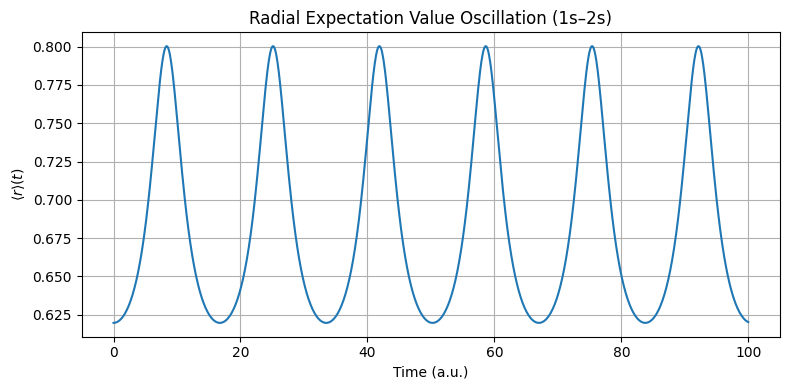

In [ ]:
#def psi_t(params, x, t):
#    return f(params, x) * jnp.exp(-1j * (E2 - E1) * t)

psi_b = jax.vmap(psi_t, in_axes=(None, 0, None))

# -------------------------
# Time grid
# -------------------------
t = jnp.linspace(0, 10.0, 1000)

# -------------------------
# Compute <r>(t)
# -------------------------
r_expect = []

for ti in t:
    psi = psi_b(params, pos, ti)
    density = jnp.abs(psi) ** 2
    r = jnp.linalg.norm(pos, axis=1)

    r_expect_t = jnp.sum(density * r) / jnp.sum(density)
    r_expect.append(r_expect_t)

r_expect = jnp.array(r_expect)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(t, r_expect)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle r \rangle(t)$")
plt.title("Radial Expectation Value Oscillation (1s–2s)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Frequency extraction

In [24]:
import numpy as np

signal = r_expect - jnp.mean(r_expect)
dt = t[1] - t[0]

fft_vals = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2

idx = np.argmax(power[1:]) + 1   # skip zero frequency
f_peak = freqs[idx]

omega_peak = 2 * np.pi * f_peak
print("Extracted ω:", omega_peak)


Extracted ω: 0.37661415


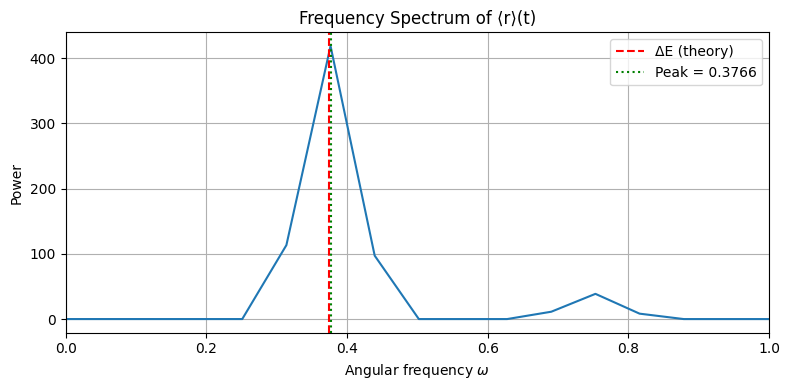

In [25]:
dt = t[1] - t[0]

signal = r_expect - np.mean(r_expect)
window = np.hanning(len(signal))

fft_vals = np.fft.rfft(signal * window)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2
omega = 2 * np.pi * freqs

plt.figure(figsize=(8, 4))
plt.plot(omega, power)
plt.axvline(0.375, color="red", linestyle="--", label="ΔE (theory)")
plt.axvline(omega[np.argmax(power[1:]) + 1],
            color="green", linestyle=":",
            label=f"Peak = {omega[np.argmax(power[1:]) + 1]:.4f}")

plt.xlim(0, 1.0)
plt.xlabel(r"Angular frequency $\omega$")
plt.ylabel("Power")
plt.title("Frequency Spectrum of ⟨r⟩(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
